<hr/>

# EN.520.637 Foundations of Reinforcement Learning

<hr/>

<h1><font color="darkblue">Lab 6: Deep Q-learning  </font></h1>



## Deadline
11:59 pm Nov 28th, 2022 

##  Content
1. Example on Cartpole



Import torch, Gym and other necessary libraries

In [1]:
%pylab inline
import matplotlib.pyplot as plt

from torch import nn
import torch
import gym
from collections import deque
import itertools
import numpy as np
import random

env = gym.make('CartPole-v1')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [2]:
GAMMA = 0.99
BATCH_SIZE = 32
BUFFER_SIZE = 50000
MIN_REPLY_SIZE = 1000
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 10000
TARGET_UPDATE_FREQ = 1000

In [3]:
class Network(nn.Module):
    def __init__(self,env):
        super().__init__()
        
        in_features = int(np.prod(env.observation_space.shape))

        self.net = nn.Sequential(
            nn.Linear(in_features,64),
            nn.Tanh(),
            nn.Linear(64,env.action_space.n))
        
    def forward(self,x):
        return self.net(x)

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()

        return action

In [4]:
replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.0],maxlen=100)
set_size = 10
step_list = deque([0.0],maxlen=set_size)


episode = 0


episode_reward = 0.0
episode_step = 0.0

n_set = 40
result = np.zeros(n_set)
counter = 0

online_net = Network(env)
target_net = Network(env)



target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)

#initiallize replay buffer
obs = env.reset()
for _ in range(MIN_REPLY_SIZE):
    action = env.action_space.sample()

    new_obs, rew, done, _ = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs

    if done:
        obs = env.reset()

# Main Training Loop
obs = env.reset()

for step in itertools.count():
    epsilon = np.interp(step, [0, EPSILON_DECAY], [EPSILON_START,EPSILON_END])

    rnd_sample = random.random()

    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        action = online_net.act(obs)

    new_obs, rew, done, _ = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs

    episode_reward += rew
    episode_step += 1

    if done:
        episode += 1
        
        obs = env.reset()
        step_list.append(episode_step)
        rew_buffer.append(episode_reward)
        episode_reward = 0.0
        episode_step = 0.0

    #Start Gradient Step
    transitions = random.sample(replay_buffer, BATCH_SIZE)

    obses = np.asarray([t[0] for t in transitions])
    actions = np.asarray([t[1] for t in transitions])
    rews = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([t[4] for t in transitions])

    obses_t = torch.as_tensor(obses, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)


    # Compute Targets
    target_q_values = target_net(new_obses_t)
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

    targets = rews_t + GAMMA*(1 - dones_t)*max_target_q_values

    # Compute Loss
    q_values = online_net(obses_t)

    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

    loss = nn.functional.smooth_l1_loss(action_q_values, targets)

    #Gradient Descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Update Target Network
    if step % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(online_net.state_dict())

    #Logging
    if episode % (set_size+1) == 0:
        episode += 1
        result[counter] = np.mean(step_list)
        print("Finishing set {}/{}...".format(counter+1,n_set),end="\r",flush=True)
        if counter == n_set-1:
            break
        counter+=1


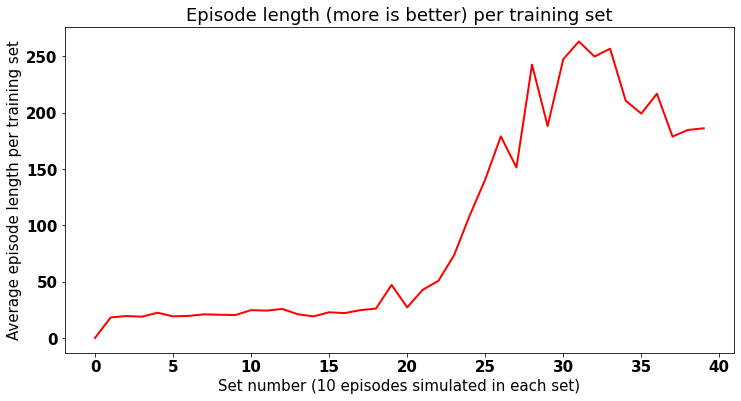

In [6]:
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

figure(figsize=(12,6))
ax = subplot(1,1,1)
ax.plot(range(len(result)), result, linewidth=2, color='r')
plt.title("Episode length (more is better) per training set")
plt.ylabel("Average episode length per training set");
plt.xlabel("Set number ({} episodes simulated in each set)".format(set_size));

#### 0. Understand the Deep Q-learning codes above, a good referance can be found in Algorithm 1 [Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015)](https://www.nature.com/articles/nature14236) <br>

### [Task 1: 10 points]. Try to apply 2 different activation functions (e.g. Sigmoid, ReLU) in the  Deep Q-learning codes above. Then, plot the average episode length (same plot as above).

### [Task 2: 10 points]. Using the best activation function you found in (1), try to modify the network stucture defined in self.net to improve the average episode length. (e.g. add/decrease number of nodes/hidden layers) Plot the average episode length.

### [Task 3: 10 points].  With the network stucture and activation function unchanged, try to modify the reward to improve the average episode length. (e.g. give more reward if angle is small) Plot it.